In [10]:
pwd

'g:\\Shared drives\\code\\projects\\pcmo\\notebooks'

# imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import xarray as xr
import sys
from tqdm.notebook import tqdm
from time import time
from glob import glob
from os.path import exists
import pandas as pd
import h5py
from scipy.ndimage import gaussian_filter
from lmfit import Model, Parameter

In [12]:
from lmfit.lineshapes import lorentzian
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset

# load data

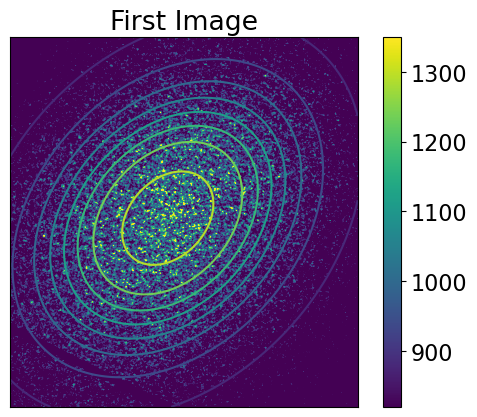

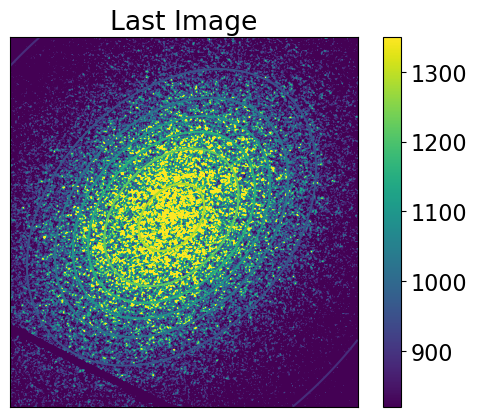

In [13]:
temp = 230
file = rf'../data\4-4-2024\{temp:.0f}k_1.h5'

roi = np.s_[150:1000, 1100:1900]
with h5py.File(file, 'r') as f:
    img = f['entry']['data']['data'][(0, *roi)]
    img1 = f['entry']['data']['data'][(-1, *roi)]



gimg = gaussian_filter(img, 35)
x, y = np.indices(gimg.shape)
mod = Model(lorentzian2d, independent_vars=['x', 'y'])
params = mod.make_params(amplitude=1e7)
params['rotation'].set(value=0.5, min=0, max=1)
params['sigmax'].set(value=250, min=100, max=400)
params['sigmay'].set(value=150, min=100, max=400)
params['centery'].set(value=365, min=200, max=500)
params['centerx'].set(value=420, min=200, max=500)
params['offset'].set(value=1)

error = 1 / np.sqrt(gimg).ravel()
result = mod.fit(img.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)
fit = mod.func(x, y, **result.best_values)


gimg = gaussian_filter(img1, 35)
error = 1 / np.sqrt(gimg).ravel()
result1 = mod.fit(img1.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)
fit1 = mod.func(x, y, **result1.best_values)

plt.figure()
plt.imshow(img, vmin=np.percentile(img, 50), vmax=np.percentile(img, 99.5))
plt.colorbar()
plt.contour(fit)
plt.xticks([])
plt.yticks([])
plt.title('First Image')
plt.show()

plt.figure()
plt.imshow(img1, vmin=np.percentile(img, 50), vmax=np.percentile(img, 99.5))
plt.colorbar()
plt.contour(fit1)
plt.xticks([])
plt.yticks([])
plt.title('Last Image')
plt.show()

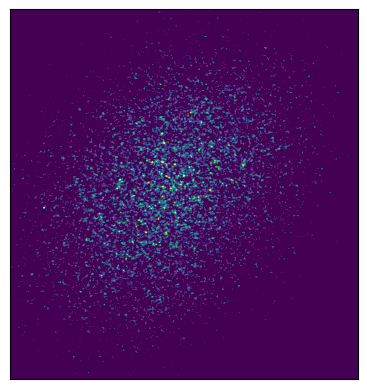

In [14]:
im = img-np.amin(img)
plt.imshow(im, vmin=300, vmax=np.percentile(im, 99.9))
#plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
result.best_values, result1.best_values

({'amplitude': 81986593.00353836,
  'centerx': 415.196630571688,
  'centery': 362.3323746963878,
  'sigmax': 307.3489543125593,
  'sigmay': 223.06410031893682,
  'rotation': 0.7463740756052045,
  'offset': 753.4441701207219},
 {'amplitude': 122823116.41198847,
  'centerx': 413.3295580335024,
  'centery': 371.00906275579166,
  'sigmax': 265.62633423831863,
  'sigmay': 189.22960965267532,
  'rotation': 0.7468079705323731,
  'offset': 790.7091776581337})

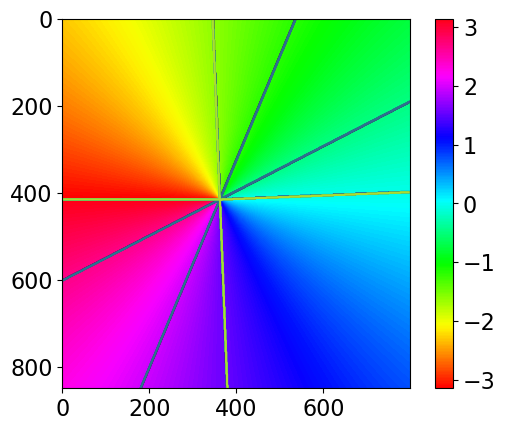

In [16]:
from skbeam.core import utils

center = (result.best_values['centerx'], result.best_values['centery'])
shape = fit.shape
angle_grid = utils.angle_grid(center, shape)
rot = result.best_values['rotation']

angle = np.deg2rad(20)
angle_label = np.zeros_like(angle_grid)
angle_label[np.logical_and(angle_grid<(rot+angle-np.pi/2), angle_grid>(rot-angle-np.pi/2))] = 1
angle_label[np.logical_and(angle_grid<(rot+angle+np.pi/2), angle_grid>(rot-angle+np.pi/2))] = 1

angle = np.deg2rad(45)
angle_label[np.logical_and(angle_grid<(rot+angle), angle_grid>(rot-angle))] = 2
angle_label[np.logical_and(angle_grid<(rot+angle-np.pi), angle_grid>(rot-angle-np.pi))] = 2

plt.imshow(angle_grid, cmap='hsv')
plt.colorbar()
plt.contour(angle_label)
plt.show()

In [17]:
pixel_size = (20e-6, 20e-6) # m
sample_distance = 305e-3 # m
wavelength = (1240/638.7) #nm Mn L3


q_grid = utils.twotheta_to_q(utils.radius_to_twotheta(sample_distance, utils.radial_grid(center, shape, pixel_size)), wavelength)

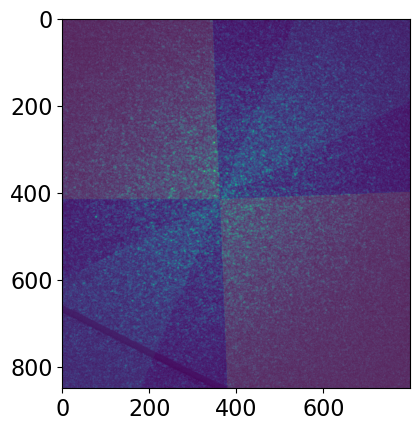

In [18]:
plt.figure()
plt.imshow(img)
plt.imshow(angle_label, alpha=0.1)
plt.show()

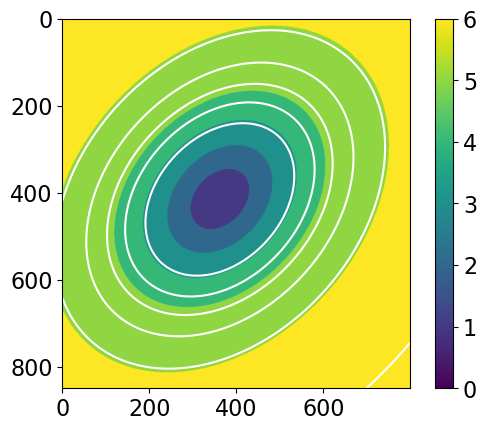

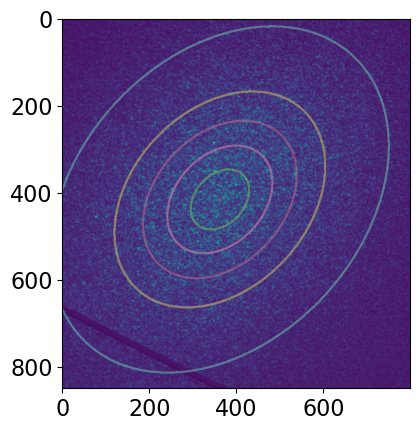

In [19]:
nfit = fit / np.amax(fit)
labels = np.zeros_like(fit)
levels = [1, .999, .99, .96, .90, .8, 0.7, 0.6]

for i in range(1, len(levels)):
    labels[np.logical_and(nfit<levels[i-1], nfit>levels[i])] = i
    
#labels[angle_label==0] = 0
#labels[np.logical_and(angle_label==2, labels!=0)] += np.amax(np.unique(labels))
    

plt.figure()
plt.imshow(labels)
plt.colorbar()
plt.contour(fit, levels=5, colors=['w'])
plt.show()

plt.figure()
plt.imshow(img)
plt.contour(labels, levels=2*len(levels)+1, alpha=0.3, cmap='tab20')
plt.show()

q = np.array([np.mean(q_grid[labels==ul]) for ul in np.unique(labels)])

In [20]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [21]:
img.shape

(850, 800)

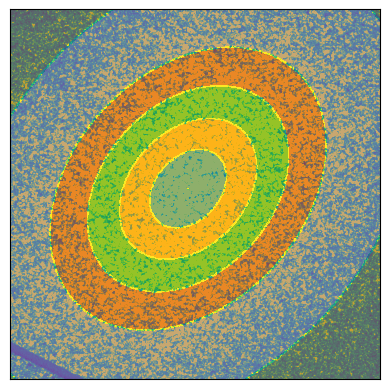

In [22]:
regions_roi = np.s_[100:750, 50:700]
plt.figure()
plt.imshow(img[regions_roi], vmax=np.percentile(im, 99.9))
for ul in np.unique(labels)[1:]:
    overlay = np.ones_like(labels).astype(float)
    overlay[labels!=ul] = np.nan
    cmap = truncate_colormap(plt.get_cmap('tab10'), 0.1*(ul-1), 0.1*(ul))
    plt.imshow(overlay[regions_roi], alpha=0.5, cmap=cmap)

plt.xticks([])
plt.yticks([])
plt.show()

q = np.array([np.mean(q_grid[labels==ul]) for ul in np.unique(labels)])

In [23]:
file = rf'../data/4-4-2024/{temp:.0f}K_g2.h5'
ds = xr.open_dataset(file)
temp = ds.temperature
ds

<xarray.Dataset>
Dimensions:   (g2: 2222, row: 850, col: 800, lags: 2222)
Coordinates:
  * lags      (lags) int32 0 1 2 3 4 5 6 ... 2215 2216 2217 2218 2219 2220 2221
  * row       (row) int32 0 1 2 3 4 5 6 7 8 ... 842 843 844 845 846 847 848 849
  * col       (col) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
Dimensions without coordinates: g2
Data variables:
    g2_stack  (g2, row, col) float64 ...
Attributes:
    temperature:  230

In [24]:
da = ds['g2_stack']
da

<xarray.DataArray 'g2_stack' (g2: 2222, row: 850, col: 800)>
[1510960000 values with dtype=float64]
Coordinates:
  * row      (row) int32 0 1 2 3 4 5 6 7 8 ... 842 843 844 845 846 847 848 849
  * col      (col) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
Dimensions without coordinates: g2

In [25]:
da.coords['labels'] = (('row', 'col'), labels.astype(int))

In [26]:
da

<xarray.DataArray 'g2_stack' (g2: 2222, row: 850, col: 800)>
[1510960000 values with dtype=float64]
Coordinates:
  * row      (row) int32 0 1 2 3 4 5 6 7 8 ... 842 843 844 845 846 847 848 849
  * col      (col) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
    labels   (row, col) int32 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6
Dimensions without coordinates: g2

In [27]:
g2s = []
for ul in tqdm(np.unique(labels)[1:]):
    tmp = da.where(da.labels==ul, drop=True).mean(axis=(1,2))
    g2s.append(tmp)

  0%|          | 0/6 [00:00<?, ?it/s]

In [28]:
g = np.array(g2s).T
g.shape

(2222, 6)

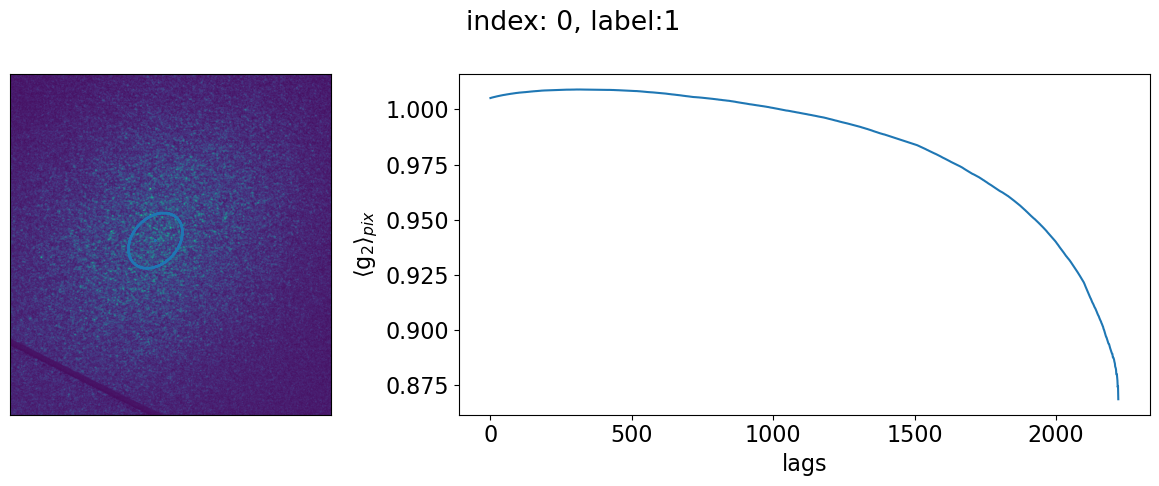

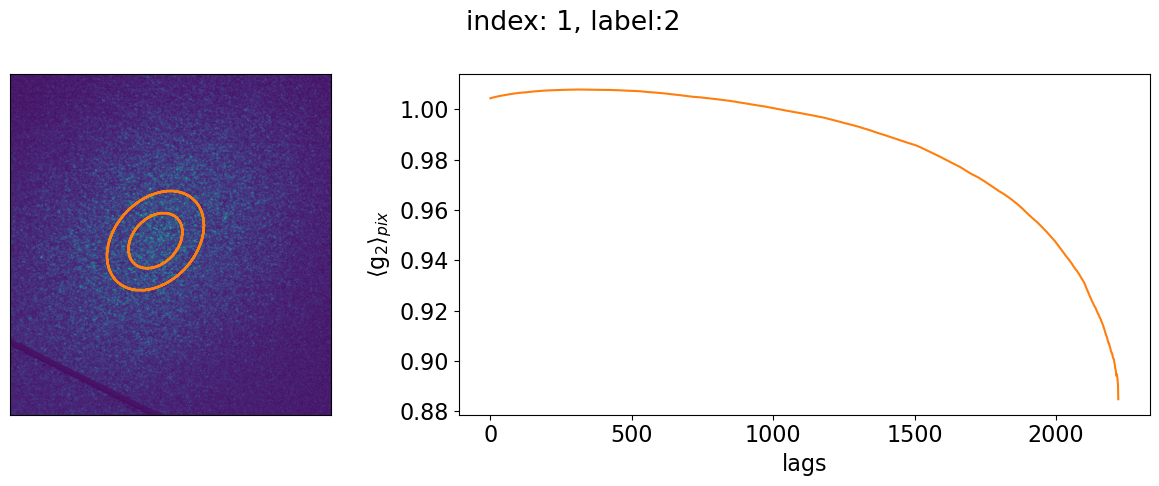

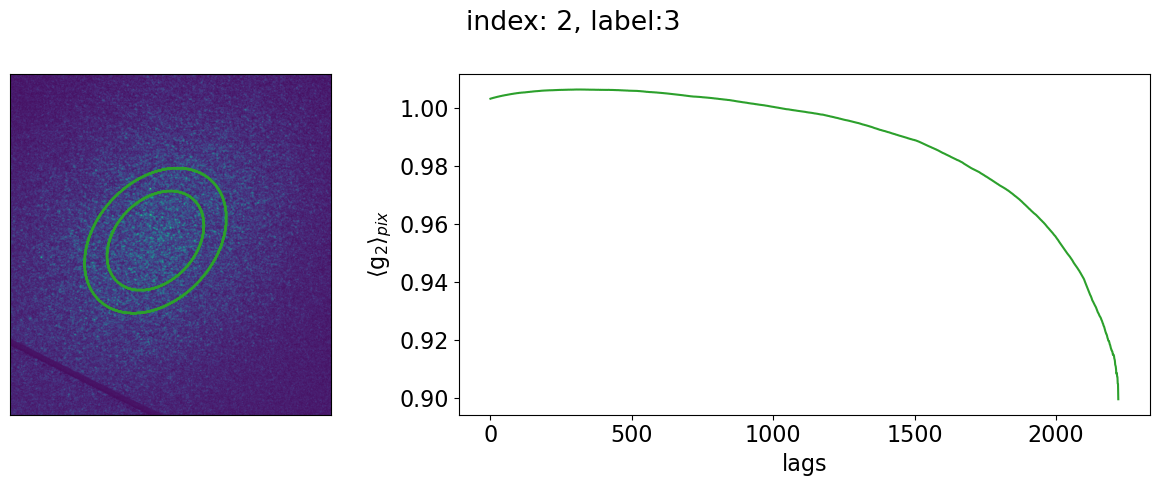

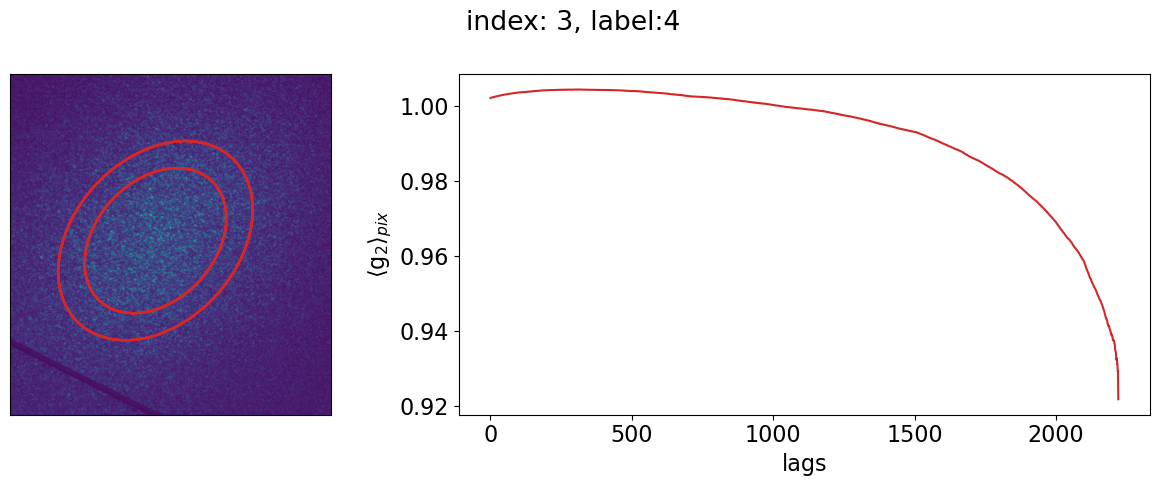

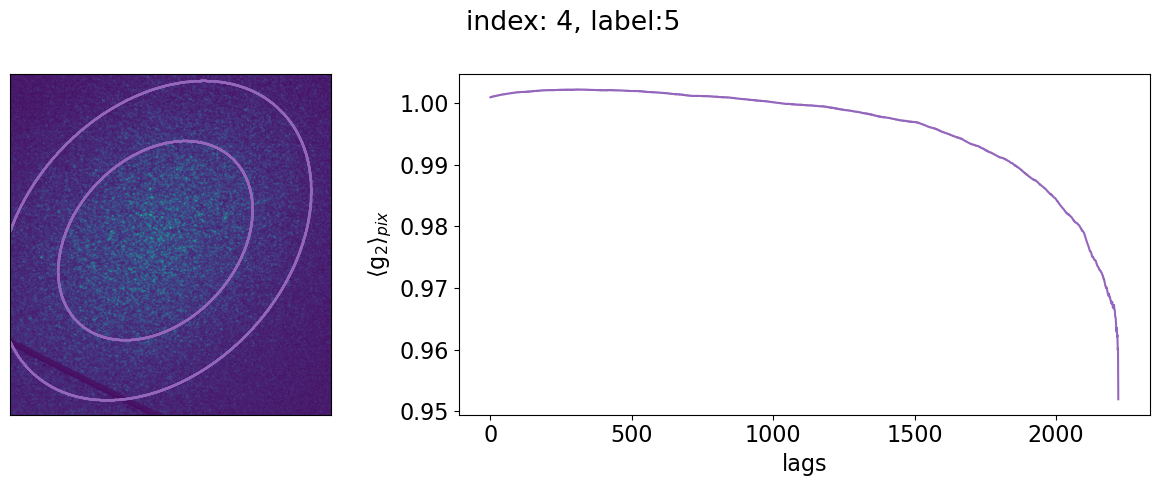

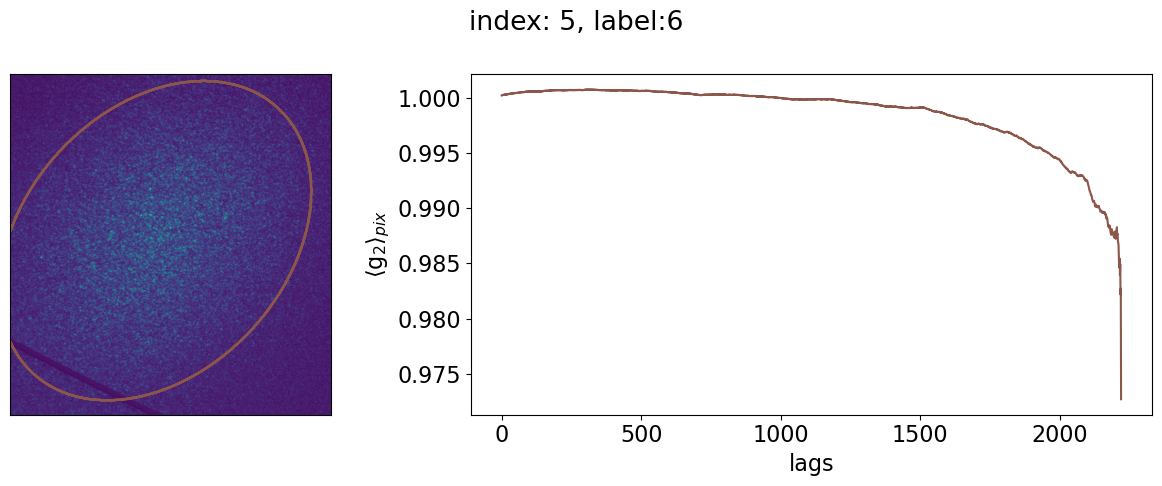

In [29]:
for ui, ul in enumerate(np.unique(labels)[1:]):
    overlay = np.zeros_like(img)
    overlay[labels==ul] = 1


    fig, ax = plt.subplots(figsize=(12,5), ncols=2, gridspec_kw={'width_ratios': [1, 2]})
    plt.suptitle(f'index: {ui}, label:{ul:.0f}')
    ax[0].imshow(img)
    ax[0].contour(overlay, colors=[f'C{ui%10:.0f}'])
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].set_ylabel(r'$\langle$g$_2 \rangle_{pix}$')
    ax[1].set_xlabel('lags')
    ax[1].plot(g[1:, ui], c=f'C{ui%10}')
    #ax[1].semilogx()
    
    plt.tight_layout()
    plt.show()

[]

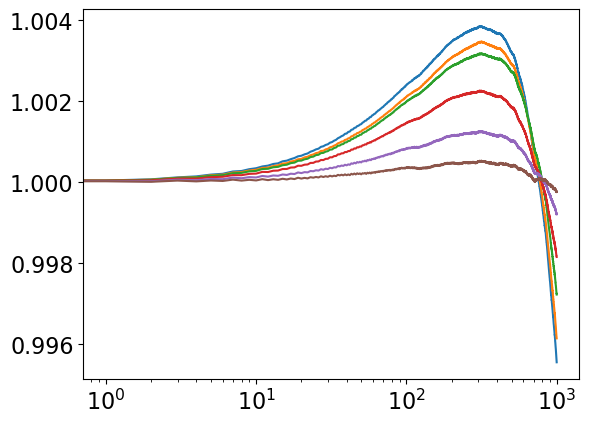

In [30]:
plt.plot(g[1:1000]/ g[1])
plt.semilogx()

[]

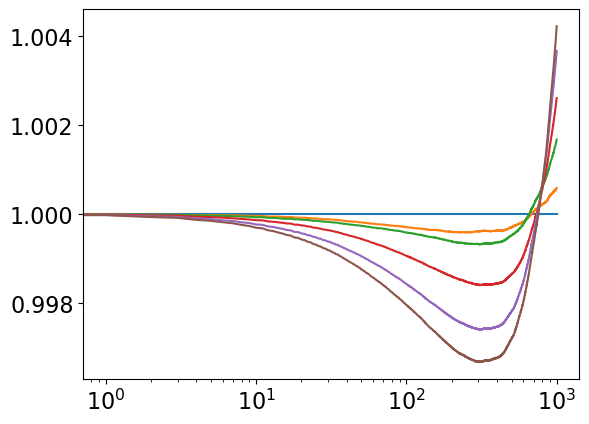

In [31]:
tmp = g[1:1000]/ g[1]
plt.plot(tmp/np.expand_dims(tmp[:, 0], axis=1))
plt.semilogx()

In [54]:
ds = xr.Dataset(
        data_vars={'g2': (('time', 'label'), g),
                   'label_image': (('row', 'col'), labels),
                   'q': (('label'), q[1:])},
        coords={
            'time': np.arange(g.shape[0]),
            'label': np.arange(g.shape[1])+1,
            'row': np.arange(labels.shape[0]),
            'col': np.arange(labels.shape[1])
        },
        attrs=dict(temperature=temp)
)
ds

<xarray.Dataset>
Dimensions:      (time: 2222, label: 6, row: 850, col: 800)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 2216 2217 2218 2219 2220 2221
  * label        (label) int32 1 2 3 4 5 6
  * row          (row) int32 0 1 2 3 4 5 6 7 ... 842 843 844 845 846 847 848 849
  * col          (col) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
Data variables:
    g2           (time, label) float64 1.013 1.012 1.011 ... 0.9836 1.015 1.037
    label_image  (row, col) float64 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0
    q            (label) float64 0.00957 0.0206 0.03212 0.0451 0.06831 0.09267
Attributes:
    temperature:  230

In [55]:
out_file = f'../data/4-4-2024/{temp}K_labelled_g2.h5'
ds.to_netcdf(out_file, engine='h5netcdf')

## end q dependence

In [62]:
temps = [220, 225, 230]


for temp in temps:
    file = f'../data/4-4-2024/{temp}K_labelled_g2.h5'
    ds = xr.open_dataset(file)
    globals()[f'g{temp}'] = ds['g2'].to_numpy()
    globals()[f'q{temp}'] = ds['q'].to_numpy()

In [113]:
g.shape

(399, 7)

In [115]:
q.shape

(7,)

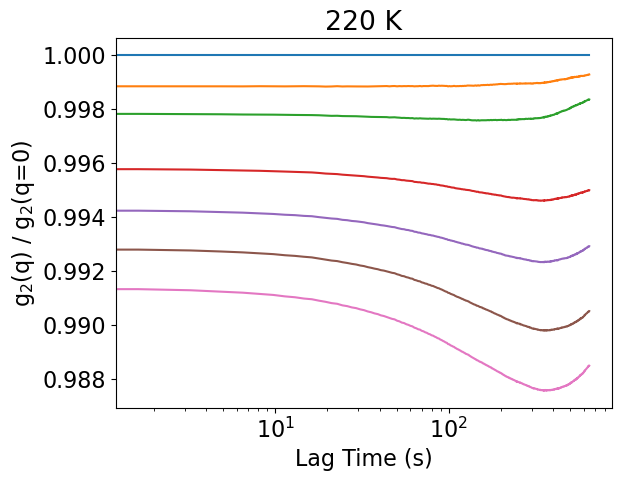

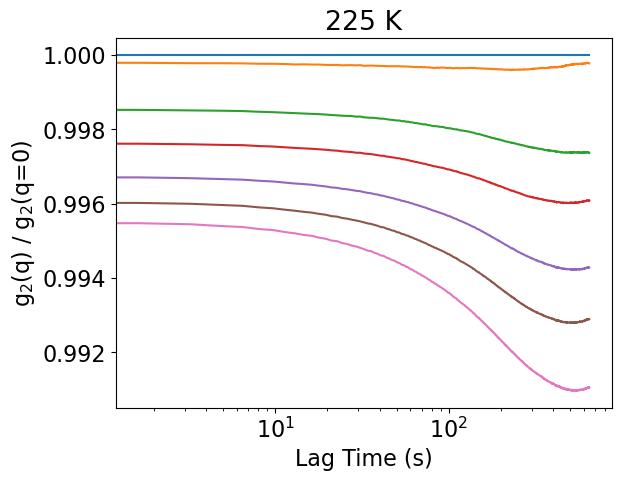

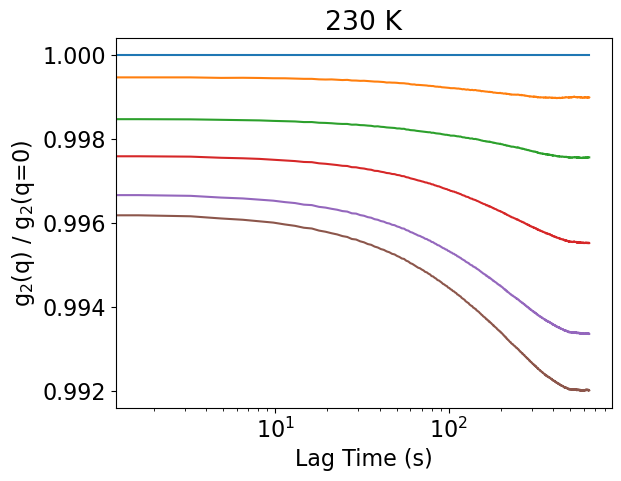

In [128]:
for temp in temps:
    g = globals()[f'g{temp}'][1:400].copy()
    g /= np.expand_dims(g[:, 0], axis=1)
    #g /= g[0]
    q = globals()[f'q{temp}']

    plt.figure()
    plt.title(f'{temp} K')
    for q_, g_ in zip(q, g.T):
        plt.plot(np.arange(len(g_[1:]))*1.625, g_[1:], label=f'q={q_:.1e} nm$^{-1}$')
    plt.semilogx()
    plt.ylabel(r'g$_2$(q) / g$_2$(q=0)')
    plt.xlabel('Lag Time (s)')
    #plt.legend(loc='right', fontsize=16)
    plt.show()

{'A': 0.004999966633924657, 'tau': 4999.999999643786, 'beta': 0.7161516014622071, 'c': 0.995}
{'A': 0.005004997909500375, 'tau': 692.7451391383763, 'beta': 0.7932954880865086, 'c': 0.995}
{'A': 0.00501007998717129, 'tau': 324.9673634386726, 'beta': 0.8200664100689594, 'c': 0.995}
{'A': 0.0050067214091575885, 'tau': 164.1968003766624, 'beta': 0.9230849131374579, 'c': 0.995}
{'A': 0.005001917763673758, 'tau': 113.66532401119677, 'beta': 0.9673246508608426, 'c': 0.995}


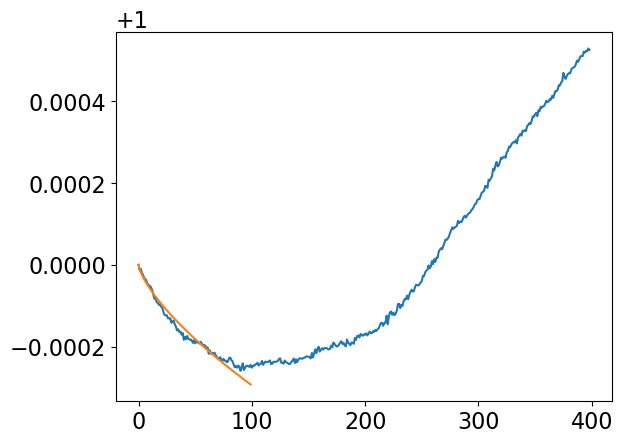

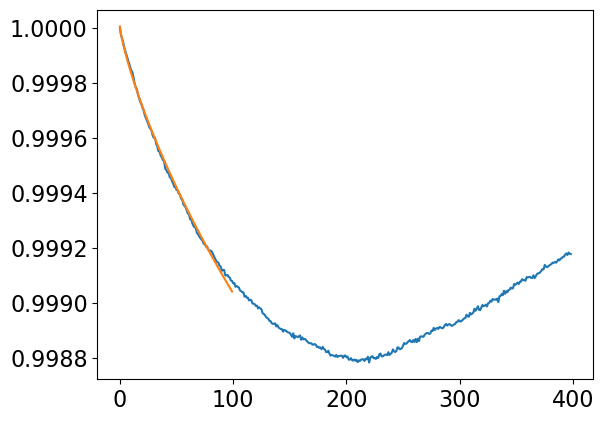

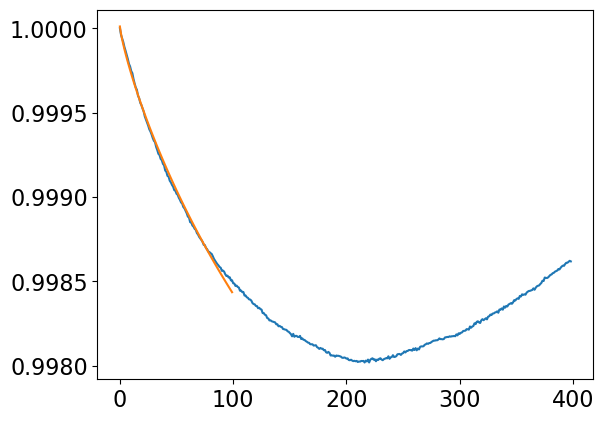

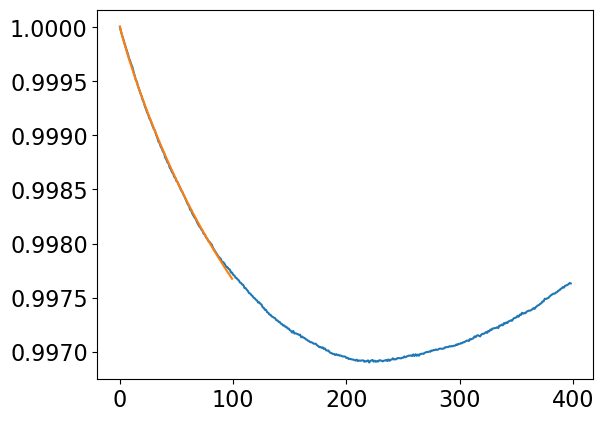

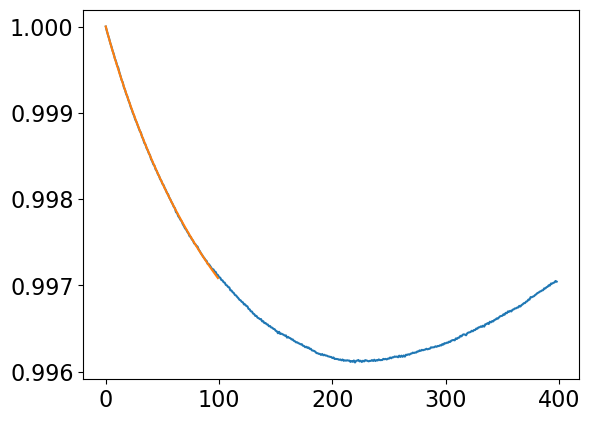

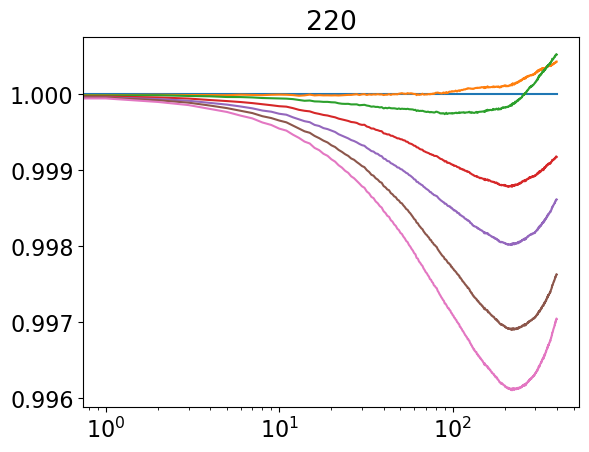

{'A': 0.005008794347336698, 'tau': 988.7383374508709, 'beta': 0.8062542132617525, 'c': 0.995}
{'A': 0.005008932028212287, 'tau': 540.3820022134669, 'beta': 0.860696467740862, 'c': 0.995}
{'A': 0.0050093918819591465, 'tau': 305.30790720724036, 'beta': 0.8836238310087361, 'c': 0.995}
{'A': 0.00500917971161674, 'tau': 199.22658472162345, 'beta': 0.9196821234268509, 'c': 0.995}
{'A': 0.005003063757026194, 'tau': 124.58813312928557, 'beta': 0.9952845749854748, 'c': 0.995}


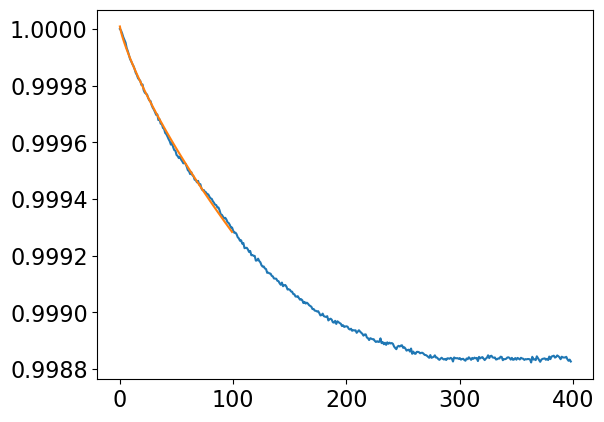

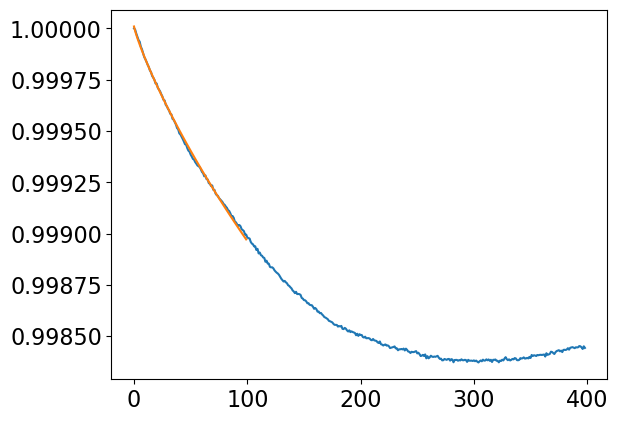

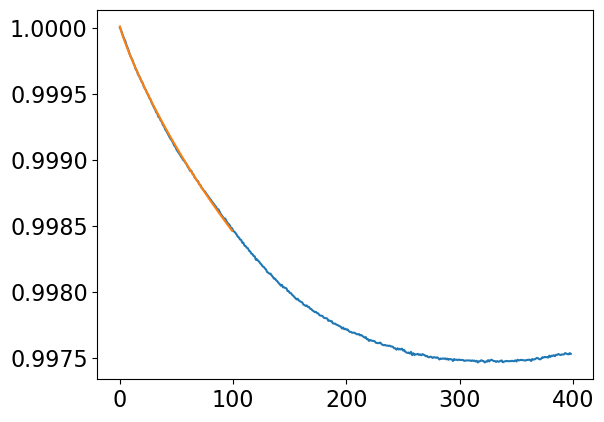

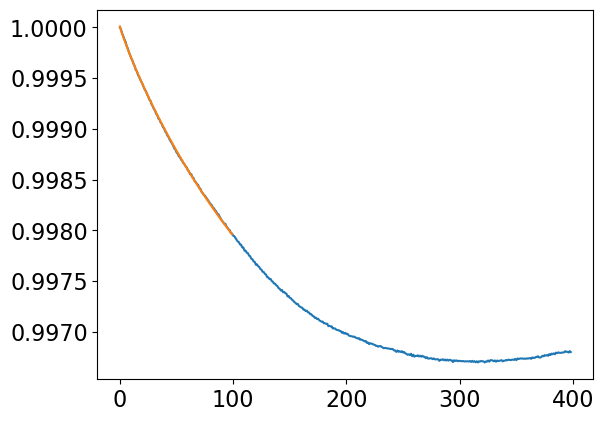

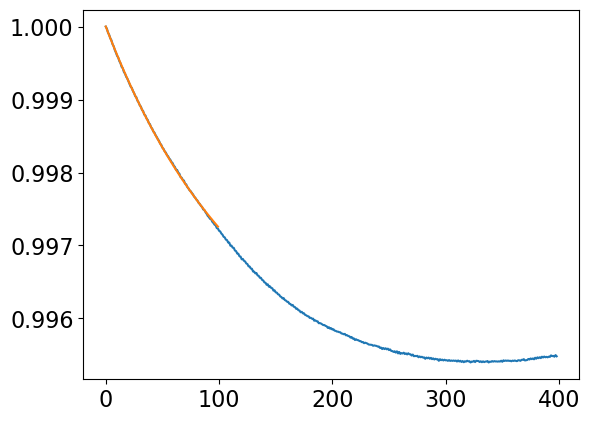

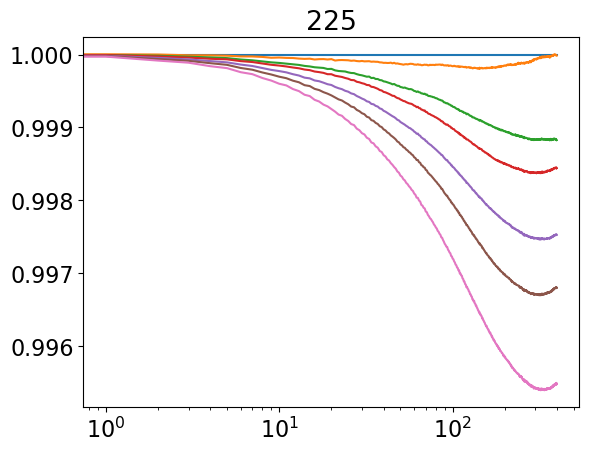

{'A': 0.0050076723741556695, 'tau': 1405.5735999931883, 'beta': 0.802452333481875, 'c': 0.995}
{'A': 0.005009107158297832, 'tau': 426.4275267643563, 'beta': 0.8854632807215577, 'c': 0.995}
{'A': 0.005009685125147767, 'tau': 210.27689980720564, 'beta': 0.9228178477047209, 'c': 0.995}
{'A': 0.005007126297328801, 'tau': 144.3020666780495, 'beta': 0.9583494860128734, 'c': 0.995}


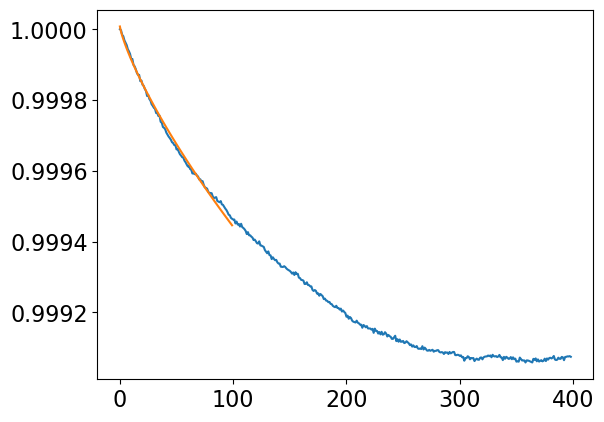

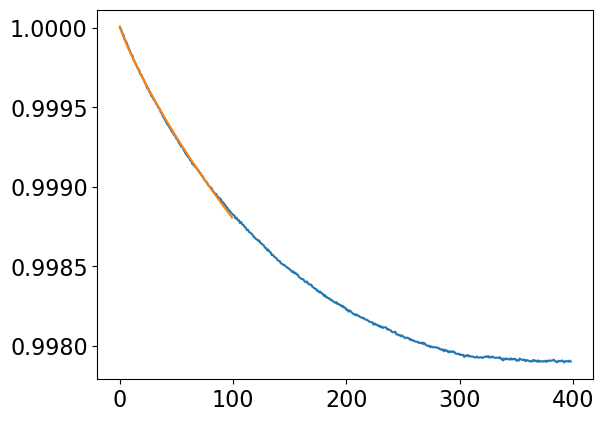

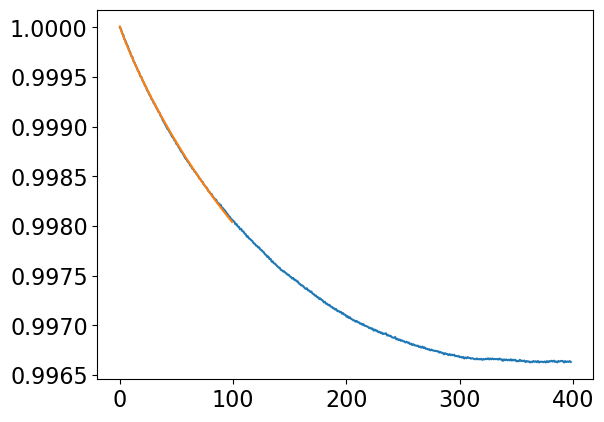

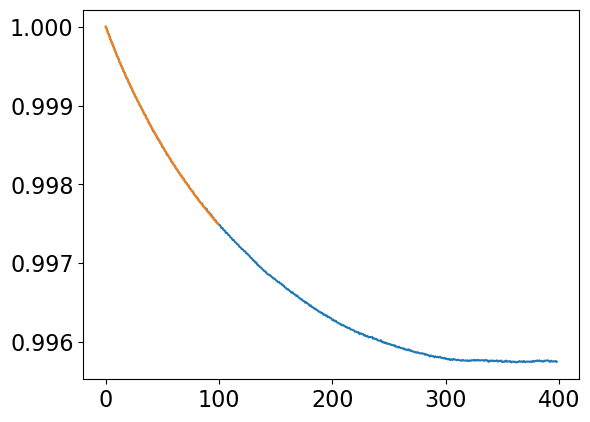

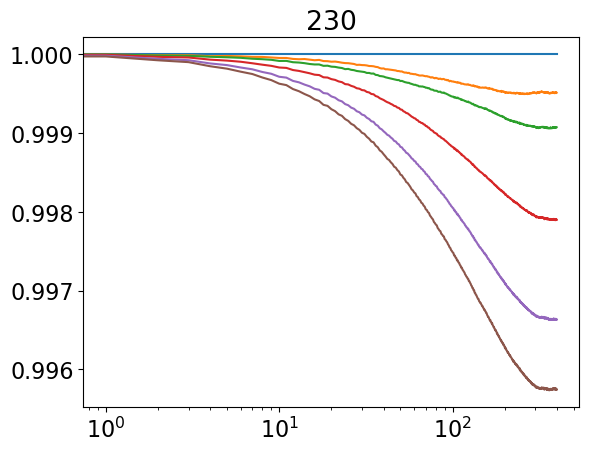

In [73]:
from lmfit import Model, Parameter

def fit_func(t, A, tau, beta, c, **kwargs):
    return A * np.exp(-(t/tau)**beta) + c

results = []
for temp in temps:
    g = globals()[f'g{temp}'][1:400].copy()
    g /= np.expand_dims(g[:, 0], axis=1)
    g /= g[0]

    tmp = []
    for gg in g.T[2:]:
        mod = Model(fit_func)
        params = mod.make_params(A=1, tau=160, beta=1, c=0.995)
        params['tau'].min = 10
        params['tau'].max = 5000
        params['c'].min = 0.8
        params['A'].min = 0
        params['c'].vary = False
        params['beta'].vary = True
        #params['beta'].max = 2
        params['beta'].min = 0
        out = mod.fit(gg[:100], t=np.arange(len(gg[:100])), params=params, weights=np.arange(1, len(gg[:100])+1)**-0.5)
        tmp.append(out)

        plt.figure()
        plt.plot(gg)
        plt.plot(out.best_fit)
        print(out.best_values)

    results.append(tmp)
    plt.figure()
    plt.title(temp)
    plt.plot(g)
    plt.semilogx()
    plt.show()

    

<ErrorbarContainer object of 3 artists>

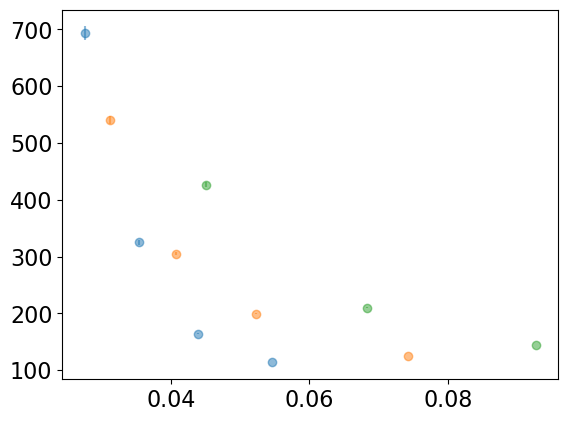

In [74]:
var = 'tau'
y = [r.best_values[var] for r in results[0]][1:]
yerr = [r.params[var].stderr for r in results[0]][1:]
plt.errorbar(q220[3:], y, yerr, fmt='o', alpha=0.5)

y = [r.best_values[var] for r in results[1]][1:]
yerr = [r.params[var].stderr for r in results[1]][1:]
plt.errorbar(q225[3:], y, yerr, fmt='o', alpha=0.5)

y = [r.best_values[var] for r in results[2]][1:]
yerr = [r.params[var].stderr for r in results[2]][1:]
plt.errorbar(q230[3:], y, yerr, fmt='o', alpha=0.5)

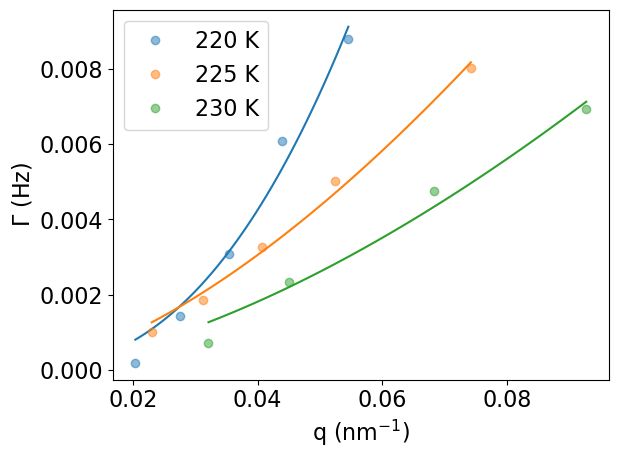

In [100]:
func = lambda x, A, pow: A * x ** pow

tmp = []

var = 'tau'
y = [1/r.best_values[var] for r in results[0]]
yerr = [r.params[var].stderr for r in results[0]]
x = q220[2:]
xx = np.linspace(min(x), max(x), 100)
mod = Model(func)
params = mod.make_params(A=1, pow=2)
params['pow'].vary = True
out = mod.fit(y, x=x, params=params)
plt.errorbar(x, y, fmt='o', alpha=0.5, color='C0', label=f'{temps[0]} K')
plt.plot(xx, func(xx, **out.best_values), 'C0')
tmp.append(out)

y = [1/r.best_values[var] for r in results[1]]
yerr = [r.params[var].stderr for r in results[1]]
x = q225[2:]
xx = np.linspace(min(x), max(x), 100)
mod = Model(func)
params = mod.make_params(A=1, pow=2)
params['pow'].vary = True
out = mod.fit(y, x=x, params=params)
plt.errorbar(x, y, fmt='o', alpha=0.5, color='C1', label=f'{temps[1]} K')
plt.plot(xx, func(xx, **out.best_values), 'C1')
tmp.append(out)

y = [1/r.best_values[var] for r in results[2]]
yerr = [r.params[var].stderr for r in results[2]]
x = q230[2:]
xx = np.linspace(min(x), max(x), 100)
mod = Model(func)
params = mod.make_params(A=1, pow=2)
params['pow'].vary = True
out = mod.fit(y, x=x, params=params)
plt.errorbar(x, y, fmt='o', alpha=0.5, color='C2', label=f'{temps[2]} K')
plt.plot(xx, func(xx, **out.best_values), 'C2')
tmp.append(out)

plt.xlabel(r'q (nm$^{-1}$)')
plt.ylabel(r'$\Gamma$ (Hz)')
plt.legend()
plt.show()

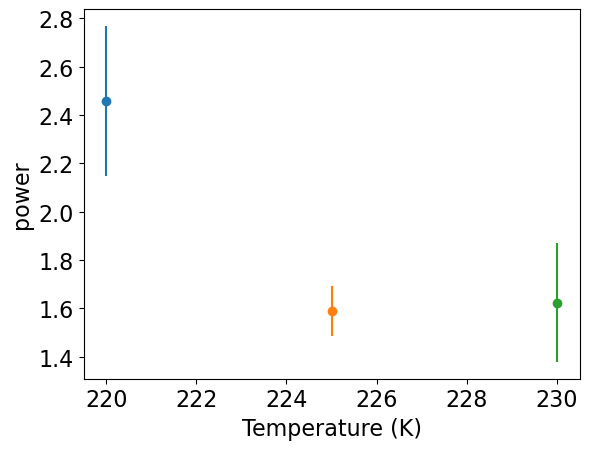

In [129]:

for i, (x_, y_, yerr_) in enumerate(zip(temps, [t.best_values['pow'] for t in tmp], [t.params['pow'].stderr for t in tmp])):
    plt.errorbar(x_, y_, yerr_, fmt='o', color=f'C{i}')

plt.xlabel('Temperature (K)')
plt.ylabel('power')
plt.show()

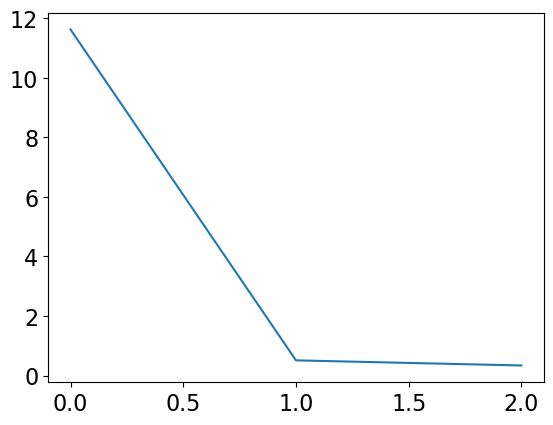

In [87]:
plt.plot([t.best_values['A'] for t in tmp])